In [1]:
import Dates
using TimeSeries, TimeSeriesResampler, Statistics
using DelimitedFiles
using HDF5
using Profile

In [2]:
import JSON

In [3]:
# IJulia.load("nortek_aquadopp_functions.jl")

In [3]:
import Dates
using HDF5
using TimeSeries
using TimeSeriesResampler
using Statistics
using DelimitedFiles

indexparser = row -> Dates.DateTime(row[3], row[1], row[2], row[4], row[5], floor(row[6]), mod(row[6],1)*1000)

function guess_filename(directory=".")
    filename = filter(x->occursin(r"\.hdr"i, x), readdir(directory))[1]
    return filename[1:end-4]
end

function isdownlooking(hdr::String)
    orientation = hdr[findnext(r"orientation.+\n"i, hdr, 1)]
    return occursin(r"downlooking"i, orientation)
end

function read_and_parse_T(hdr::String)
    downlooking = isdownlooking(hdr)
    T = hdr[findnext(r"Transformation matrix.+\n.+\n.+\n", hdr, 1)]
    T = reshape(split(T)[3:end], 3, 3)
    T = transpose(parse.(Float64, T))
    if downlooking
        T[2, :] = -T[2, :]
        T[3, :] = -T[3, :]
    end
    return T
end
    
function parse_Nortek_HDR_file(filename::String)
    hdr = read("$(filename).hdr", String)
    downlooking = isdownlooking(hdr)
    T = read_and_parse_T(hdr)
    return T
end

function parse_sen(filename::String)
    sen = readdlm("$filename.sen")
    index = mapslices(indexparser, sen, dims=2)[:]
    hpr = TimeArray(index, sen[:, 13:15],  Symbol.(["Heading", "Pitch", "Roll"]))
    burst_id = sen[:, 7][:]
    sample_id = sen[:, 8][:]
    return index, hpr, burst_id, sample_id
end  

function get_R_matrices(hh, pp, rr, T)
    H = [cos(hh) sin(hh) 0;
        -sin(hh) cos(hh) 0;
        0 0 1
        ]
    P = [
        cos(pp) -sin(pp)*sin(rr) -cos(rr)*sin(pp);
        0 cos(rr) -sin(rr);
        sin(pp) sin(rr)*cos(pp) cos(pp)*cos(rr);
        ]
    return H*P*T
end

function create_beam_to_reynolds_stress_matrix(R::Array{Float64, 2})
    if size(R) != (3,3)
        error("R matrix should be 3x3")
    end
    b2rs = hcat(
        R[:,1].^2,
        2*R[:,1].*R[:,2],
        2*R[:,1].*R[:,3],
        R[:,2].^2,
        2*R[:,2].*R[:,3],
        R[:,3].^2,
    )
    return b2rs
end

# function (filename::Union{String, Nothing})
#     if filename == nothing
#         filename = guess_filename()
#     end

function detrend(array::TimeArray, window::Int)
    index = timestamp(array)
    return TimeArray(index, (values(array) - values(moving(mean, array, window, padding=true))))
end


detrend (generic function with 1 method)

$$
\begin{bmatrix} u^2_1 \\ u_1u_2 \\ u_1u_3 \\ u^2_2 \\ u_2u_3 \\ u^2_3 \end{bmatrix}
=
\begin{bmatrix}
b_{1 \parallel} \\ b_{2 \parallel} \\ b_{3 \parallel} \\ b_{1 \perp} \\ b_{2 \perp} \\ b_{3 \perp}
\end{bmatrix}
*
inv \begin{bmatrix} b2R \end{bmatrix}
$$

In [4]:
directories = Dict(
    '⟂'=>"/home/taranarmo/Documents/NWPI/data/2019kilpis/aquadopp/Aquadopp_perpend_to_ice/",
    '∥'=>"/home/taranarmo/Documents/NWPI/data/2019kilpis/aquadopp/Aquadopp_parallelto_to_ice/",
);

In [5]:
function get_b2r_matrix(dir)
    curdir = pwd(); cd(dir)
    filename = guess_filename()
    T = parse_Nortek_HDR_file(filename)
    index, hpr = parse_sen(filename)
    hpr = mean(resample(hpr, Dates.Minute(1)))
    R = zeros(size(hpr)[1], 3, 3)
    for (i, orientation) in enumerate(eachrow(values(hpr)))
        R[i, :, :] = inv(get_R_matrices(orientation..., T))
    end
    cd(curdir)
    return mapslices(create_beam_to_reynolds_stress_matrix, R, dims=[2,3])
end

get_b2r_matrix (generic function with 1 method)

In [6]:
function get_b2r_matrix(dir)
    curdir = pwd(); cd(dir)
    filename = guess_filename()
    T = parse_Nortek_HDR_file(filename)
    index, hpr = parse_sen(filename)
    hpr = values(mean(hpr, dims=1))
    R = get_R_matrices(values(hpr)..., T)
    cd(curdir)
    return R
end

get_b2r_matrix (generic function with 1 method)

In [9]:
@profile R1 = get_b2r_matrix(directories['∥'])
@profile R2 = get_b2r_matrix(directories['⟂'])

3×3 Array{Float64,2}:
  0.346647   1.20091   -0.799071
 -0.108208   0.566944  -1.26823 
  1.57846   -0.927784  -0.614373

In [18]:
R1

3×3 Array{Float64,2}:
 0.112695  -0.660929   1.30719 
 1.54524   -0.22308   -0.906758
 0.472141  -1.46212    0.305682

In [8]:
function read_R(directory::String)
    filename = guess_filename(directory)
    json = read("$(directory)rotation.json", String)
    json = JSON.parse(json)
    hpr = [json["Heading"]-π/2, json["Pitch"], json["Roll"]]
    T = read_and_parse_T(read("$(directory)$(filename).hdr", String))
    return get_R_matrices(hpr..., T)
end

read_R (generic function with 1 method)

In [9]:
(R1, R2) = read_R(directories['∥']), read_R(directories['⟂'])

([0.0315306 -1.38156 1.3503; 1.57714 -0.761664 -0.816119; -0.36747 -0.36816 -0.36747], [0.118055 -1.42158 1.30315; 1.57319 -0.684317 -0.888997; -0.366769 -0.367712 -0.36862])

In [10]:
single_b2r = inv(vcat(
    create_beam_to_reynolds_stress_matrix(R1),
    create_beam_to_reynolds_stress_matrix(R2),
));

# Reading data

In [22]:
function read_and_prepare_data(directory::String)
    hdf = h5read("$(directory)$(guess_filename(directory))_beam.hdf5", "beam")
    hdf["block0_values"] = Float64.(transpose(hdf["block0_values"]))
    currents = mean(
        resample(
            TimeArray(
                unix2datetime.(hdf["axis1_level0"]./1e9),
                hdf["block0_values"],
                ),
            Minute(1),
            ),
    )
    return hdf
#             Dict(
#         "currents"=>values(currents),
#         "index"=>timestamp(currents),
#         "cells"=>hdf["axis0_level1"],
#         "comps"=>hdf["axis0_level0"],
#         )
end

read_and_prepare_data (generic function with 1 method)

In [14]:
adcp_data = read_and_prepare_data(directories['⟂']);

In [ ]:
function detrend(adcp_data, window::Int64)
    currents = adcp["currents"]
    

In [15]:
currents = TimeArray(adcp_data["index"], adcp_data["currents"])
# moving(mean, currents, 100)

4969×225 TimeArray{Float64,2,DateTime,Array{Float64,2}} 2019-05-13T19:39:00 to 2019-05-17T06:27:00
│                     │ A       │ B       │ C       │ D       │ E       │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 2019-05-13T19:39:00 │ -0.0014 │ -0.0015 │ -0.0017 │ -0.0017 │ -0.0018 │
│ 2019-05-13T19:40:00 │ -0.0014 │ -0.0016 │ -0.0017 │ -0.0017 │ -0.0018 │
│ 2019-05-13T19:41:00 │ -0.0014 │ -0.0016 │ -0.0017 │ -0.0017 │ -0.0018 │
│ 2019-05-13T19:42:00 │ -0.0014 │ -0.0016 │ -0.0017 │ -0.0018 │ -0.0018 │
│ 2019-05-13T19:43:00 │ -0.0014 │ -0.0016 │ -0.0017 │ -0.0018 │ -0.0018 │
│ 2019-05-13T19:44:00 │ -0.0014 │ -0.0016 │ -0.0017 │ -0.0018 │ -0.0018 │
│ 2019-05-13T19:45:00 │ -0.0014 │ -0.0016 │ -0.0017 │ -0.0018 │ -0.0018 │
│ 2019-05-13T19:46:00 │ -0.0015 │ -0.0016 │ -0.0017 │ -0.0018 │ -0.0018 │
│ 2019-05-13T19:47:00 │ -0.0015 │ -0.0016 │ -0.0017 │ -0.0018 │ -0.0018 │
│ 2019-05-13T19:48:00 │ -0.0015 │ -0.0016 │ -0.0017 │ -0.0018 │ -0.0018 │
│ 2019-05-13T

In [ ]:
function get_cell(currents, depth)
    ind = findmin(abs.(colnames(currents)))

In [25]:
ind = findmin(abs.(hdf["axis0_level1"] .- 1))[2]

32

In [27]:
values(currents)[:, hdf["axis0_label1"] .== ind]

5057×3 Array{Float64,2}:
  0.003112  -0.005084   0.002296
  0.003398  -0.005454   0.003022
  0.003302  -0.004938   0.00225 
  0.00332   -0.00538    0.00258 
  0.003768  -0.005194   0.002258
  0.00311   -0.004992   0.003106
  0.00386   -0.005402   0.002566
  0.003532  -0.00544    0.002674
  0.003652  -0.005316   0.001966
  0.003684  -0.004772   0.002112
  0.003924  -0.004126   0.001318
  0.00379   -0.004894   0.002222
  0.00383   -0.004796   0.00138 
  ⋮                             
  0.002152   0.008118  -0.006514
  0.004238   0.005834  -0.00133 
 -0.010588  -0.002584  -0.004408
 -0.004818  -0.005218   0.004182
 -0.002786  -0.005736   0.00329 
 -0.011452  -0.001292   0.000438
  0.005496  -8.6e-5     0.00251 
  0.000332   0.00621   -0.00507 
  0.004918   0.003276  -0.000256
  0.002464  -0.000582  -0.010152
  0.001974   0.003382   0.005564
  0.006396  -0.004694  -0.007818

In [12]:
reynolds_stress = zeros(size(v)[1], 6)
for (i, current_data) in enumerate(eachrow(v))
    reynolds_stress[i, :] = single_b2r * current_data.^2
end

In [12]:
function align_and_stack_b2r_matrices(directories)
    R1 = get_b2r_matrix(directories[1])
    R2 = get_b2r_matrix(directories[2])
    minimal_size = minimum([size(R)[1] for R in [R1, R2]])
    R1, R2 = [R[1:minimal_size, :, :] for R in [R1, R2]]
    R = hcat(R1, R2)
    R = mapslices(inv, R, dims=(2,3))
end

align_and_stack_b2r_matrices (generic function with 1 method)

In [6]:
cd("/home/taranarmo/Documents/NWPI/kilpisjarvi2019/")

In [13]:
b2rs = align_and_stack_b2r_matrices([directories['∥'], directories['⟂']]);

In [12]:
function get_beam_currents_data(directory)
    filename = guess_filename(directory)
    index, = parse_sen("$directory/$filename")
    values = [readdlm("$directory/$filename.v$i", Float16)[:, 8][:] for i in [1,2,3]]
    data = TimeArray(index, hcat(values...))
    return mean(resample(data, Dates.Minute(1)))
end

get_beam_currents_data (generic function with 1 method)

In [17]:
import Profile

In [12]:
function read_and_align_current_data(directories)
    v1 = get_beam_currents_data(directories[1])
    v2 = get_beam_currents_data(directories[2])
    minimal_size = minimum([size(data)[1] for data in [v1, v2]])
    index = timestamp(v1)[1:minimal_size]
    v1, v2 = [values(data)[1:minimal_size, :] for data in [v1, v2]]
    return TimeArray(index, hcat(v1, v2))
end

read_and_align_current_data (generic function with 1 method)

In [ ]:
function get_data()
    v = read_and_align_current_data([directories['∥'], directories['⟂']]);
    v = detrend(v, 100);
    v = moving(mean, v, 100);
    index = timestamp(v)
    v = values(v);
    return v
end
@profile v = get_data();

In [44]:
reynolds_stress = zeros(size(v)[1], 6)
for (i, current_data) in enumerate(eachrow(v))
    reynolds_stress[i, :] = b2rs[i, :, :] * current_data.^2
end

In [14]:
using Plots

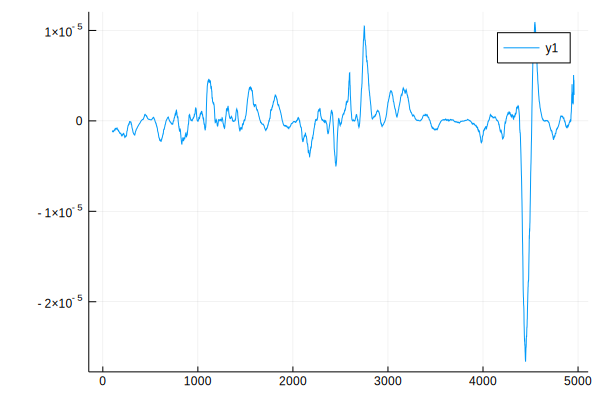

In [15]:
plot(reynolds_stress[:, 1])

In [14]:
h5write("reynolds_stress.hdf5", "reynolds_stress", reynolds_stress)

In [21]:
h5write("reynolds_stress.hdf5", "index", Dates.datetime2unix.(index))

In [23]:
writedlm("reynolds_stress.txt", reynolds_stress)

In [21]:
writedlm("reynolds_stress_index.txt", "index", Dates.datetime2unix.(index))

In [25]:
writetimearray(TimeArray(index, reynolds_stress), "reynolds_stress.csv")

In [ ]:
reynolds_stress = 